In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install pyEDM
import pyEDM as edm
import pickle
import random

import os



from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
'''
Binary prediction skill (“bloom” or “no bloom”) is
evaluated by how well bloom predictions above a defined threshold
correspond to bloom observations above the same threshold
Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
'''
def thresh_bloom_binary_prediction(obs,pred,threshold=8.03199999999999):
    #obs_bloom_95 = np.percentile(obs, 95) #incorrect
    #pred_bloom_95 = np.percentile(pred, 95) #incorrect
    obs_blooms = obs > threshold
    pred_blooms = pred > threshold
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]

In [3]:
'''
Binary prediction skill (“bloom” or “no bloom”) is
evaluated by how well bloom predictions (5% largest predicted values)
correspond to bloom observations (5%largest observed values)
Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
'''
def bloom_binary_prediction(obs,pred):
    obs_bloom_95 = np.percentile(obs, 95) #incorrect
    pred_bloom_95 = np.percentile(pred, 95) #incorrect
    obs_blooms = obs > obs_bloom_95
    pred_blooms = pred > pred_bloom_95
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]

In [4]:

paper_data = pd.read_csv('Data/data_w_gaps_and_wind.csv')
paper_data = paper_data.set_index('time')
paper_data['Time'] = paper_data.index.astype(int)
paper_data['Avg_Chloro'] = paper_data['Avg_Chloro'].apply(np.log)
paper_data
#np.percentile(paper_data['Avg_Chloro'].dropna(), 95)

Avg_Chloro  Nitrate  Phosphate  Silicate  Nitrite  SURF_TEMP_C  \
time                                                                   
0       0.598837     0.43       0.24       5.6     0.03         20.3   
7       0.996949     0.83       0.37       5.1     0.04         17.8   
13     -0.010050     0.45       0.24       3.5     0.00         22.2   
20      0.207014     0.34       0.17       4.2     0.00         19.8   
28      0.879627     0.29       0.12       3.8     0.00         22.5   
...          ...      ...        ...       ...      ...          ...   
5789    1.169381     0.85       0.30       6.2     0.00         17.4   
5796    1.220830     0.45       0.25       4.9     0.00         17.9   
5803    2.056685     0.00       0.17       5.2     0.00         18.3   
5811    2.850707     0.00       0.20       9.4     0.00         18.0   
5817    2.816007     0.00       0.10       7.5     0.00         18.4   

      BOT_TEMP_C  SURF_SAL_PSU  BOT_SAL_PSU  SURF_DENS_kgm3  BOT_DENS_kgm3  \
time                                                                         
0           15.9         33.77        33.62     1023.638094    1024.620655   
7           16.9         33.66        33.62     1024.186379    1024.391719   
13          18.3         33.74        33.58     1023.100557    1024.026040   
20          19.4         33.68        33.62     1023.701088    1023.780535   
28          22.5         33.73        33.69     1023.009067    1023.000725   
...          ...           ...          ...             ...            ...   
5789        17.4         33.48        33.46     1024.146195    1024.152950   
5796        17.9         33.48        33.47     1024.026335    1024.040616   
5803        16.4         33.54        33.55     1023.974093    1024.454252   
5811        17.4         33.64        33.61     1024.122823    1024.266323   
5817        17.2         33.63        33.62     1024.017322    1024.321284   

      AVG_TEMP_C  AVG_SAL_PSU  AVG_DENS_kgm3      WSPD  Time  
time                                                          
0          18.10       33.695    1024.129374  4.691667     0  
7          17.35       33.640    1024.289049  2.787500     7  
13         20.25       33.660    1023.563298  3.412500    13  
20          9.90       33.650    1023.740812  3.495833    20  
28         11.25       33.710    1023.004896  2.604167    28  
...          ...          ...            ...       ...   ...  
5789       17.40       33.470    1024.149572  5.076389  5789  
5796       17.90       33.475    1024.033476  2.737500  5796  
5803       17.35       33.545    1024.214172  3.306250  5803  
5811       17.70       33.625    1024.194573  2.418056  5811  
5817       17.80       33.625    1024.169303  2.568056  5817  

[832 rows x 16 columns]

In [5]:
time_series = paper_data[['Time', 'Nitrate', 'Phosphate', 'Silicate',  'Nitrite', 'AVG_TEMP_C', 'AVG_SAL_PSU', 'AVG_DENS_kgm3', 'Avg_Chloro']]
print(time_series)

      Time  Nitrate  Phosphate  Silicate  Nitrite  AVG_TEMP_C  AVG_SAL_PSU  \
time                                                                         
0        0     0.43       0.24       5.6     0.03       18.10       33.695   
7        7     0.83       0.37       5.1     0.04       17.35       33.640   
13      13     0.45       0.24       3.5     0.00       20.25       33.660   
20      20     0.34       0.17       4.2     0.00        9.90       33.650   
28      28     0.29       0.12       3.8     0.00       11.25       33.710   
...    ...      ...        ...       ...      ...         ...          ...   
5789  5789     0.85       0.30       6.2     0.00       17.40       33.470   
5796  5796     0.45       0.25       4.9     0.00       17.90       33.475   
5803  5803     0.00       0.17       5.2     0.00       17.35       33.545   
5811  5811     0.00       0.20       9.4     0.00       17.70       33.625   
5817  5817     0.00       0.10       7.5     0.00       17.80   

In [6]:
embedded = edm.Embed(
    dataFrame = time_series, 
    columns = 'Nitrate Phosphate Silicate Nitrite AVG_TEMP_C AVG_SAL_PSU AVG_DENS_kgm3 Avg_Chloro',
    E = 3,
    tau=-1
)
embedded

Nitrate(t-0)  Phosphate(t-0)  Silicate(t-0)  Nitrite(t-0)  \
time                                                              
0             0.43            0.24            5.6          0.03   
7             0.83            0.37            5.1          0.04   
13            0.45            0.24            3.5          0.00   
20            0.34            0.17            4.2          0.00   
28            0.29            0.12            3.8          0.00   
...            ...             ...            ...           ...   
5789          0.85            0.30            6.2          0.00   
5796          0.45            0.25            4.9          0.00   
5803          0.00            0.17            5.2          0.00   
5811          0.00            0.20            9.4          0.00   
5817          0.00            0.10            7.5          0.00   

      AVG_TEMP_C(t-0)  AVG_SAL_PSU(t-0)  AVG_DENS_kgm3(t-0)  Avg_Chloro(t-0)  \
time                                                                           
0               18.10            33.695         1024.129374         0.598837   
7               17.35            33.640         1024.289049         0.996949   
13              20.25            33.660         1023.563298        -0.010050   
20               9.90            33.650         1023.740812         0.207014   
28              11.25            33.710         1023.004896         0.879627   
...               ...               ...                 ...              ...   
5789            17.40            33.470         1024.149572         1.169381   
5796            17.90            33.475         1024.033476         1.220830   
5803            17.35            33.545         1024.214172         2.056685   
5811            17.70            33.625         1024.194573         2.850707   
5817            17.80            33.625         1024.169303         2.816007   

      Nitrate(t-1)  Phosphate(t-1)  ...  AVG_DENS_kgm3(t-1)  Avg_Chloro(t-1)  \
time                                ...                                        
0              NaN             NaN  ...                 NaN              NaN   
7             0.43            0.24  ...         1024.129374         0.598837   
13            0.83            0.37  ...         1024.289049         0.996949   
20            0.45            0.24  ...         1023.563298        -0.010050   
28            0.34            0.17  ...         1023.740812         0.207014   
...            ...             ...  ...                 ...              ...   
5789          0.99            0.22  ...         1023.990298         1.393766   
5796          0.85            0.30  ...         1024.149572         1.169381   
5803          0.45            0.25  ...         1024.033476         1.220830   
5811          0.00            0.17  ...         1024.214172         2.056685   
5817          0.00            0.20  ...         1024.194573         2.850707   

      Nitrate(t-2)  Phosphate(t-2)  Silicate(t-2)  Nitrite(t-2)  \
time                                                              
0              NaN             NaN            NaN           NaN   
7              NaN             NaN            NaN           NaN   
13            0.43            0.24            5.6          0.03   
20            0.83            0.37            5.1          0.04   
28            0.45            0.24            3.5          0.00   
...            ...             ...            ...           ...   
5789          1.00            0.28            6.3          0.00   
5796          0.99            0.22            8.1          0.00   
5803          0.85            0.30            6.2          0.00   
5811          0.45            0.25            4.9          0.00   
5817          0.00            0.17            5.2          0.00   

      AVG_TEMP_C(t-2)  AVG_SAL_PSU(t-2)  AVG_DENS_kgm3(t-2)  Avg_Chloro(t-2)  
time                                                                          
0                 NaN 

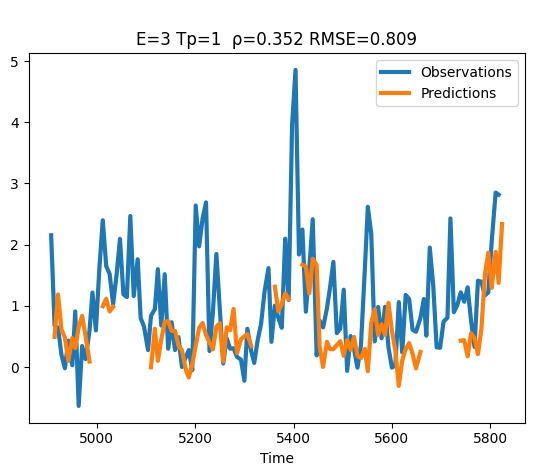

       Time  Observations  Predictions  Pred_Variance
0    4907.0      2.152924          NaN            NaN
1    4914.0      0.678034     0.493003       0.492402
2    4921.0      0.641854     1.185909       1.097029
3    4928.0      0.198851     0.617444       0.316734
4    4935.0     -0.020203     0.481238       0.359660
..      ...           ...          ...            ...
127  5796.0      1.220830     1.870413       0.734561
128  5803.0      2.056685     1.293858       0.923941
129  5811.0      2.850707     1.881983       0.901435
130  5817.0      2.816007     1.374959       0.666197
131  5824.0           NaN     2.336939       0.283135

[132 rows x 4 columns]


In [7]:
result = edm.Simplex(
    dataFrame = time_series, 
    columns = 'Nitrate Phosphate Silicate Nitrite AVG_TEMP_C AVG_SAL_PSU AVG_DENS_kgm3 Avg_Chloro',
    target = 'Avg_Chloro',
    lib = '1 701',  # Library from rows 0 to 700
    pred = '702 832',
    E = 3,
    showPlot = True
)
print(result)

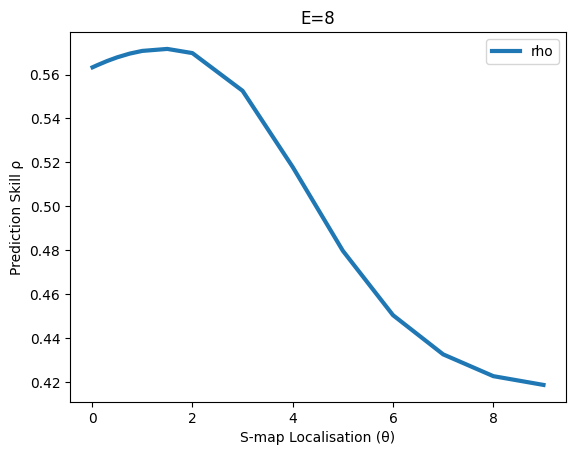

theta       rho
0    0.01  0.563296
1    0.10  0.564228
2    0.30  0.566153
3    0.50  0.567832
4    0.75  0.569530
5    1.00  0.570757
6    1.50  0.571663
7    2.00  0.569767
8    3.00  0.552608
9    4.00  0.517895
10   5.00  0.479744
11   6.00  0.450422
12   7.00  0.432580
13   8.00  0.422660
14   9.00  0.418667

In [8]:
edm.PredictNonlinear( dataFrame = time_series, lib = '1 701', pred = '702 832',
                  columns = 'Nitrate Phosphate Silicate Nitrite AVG_TEMP_C AVG_SAL_PSU AVG_DENS_kgm3 Avg_Chloro', target = 'Avg_Chloro', E = 3, embedded=True )

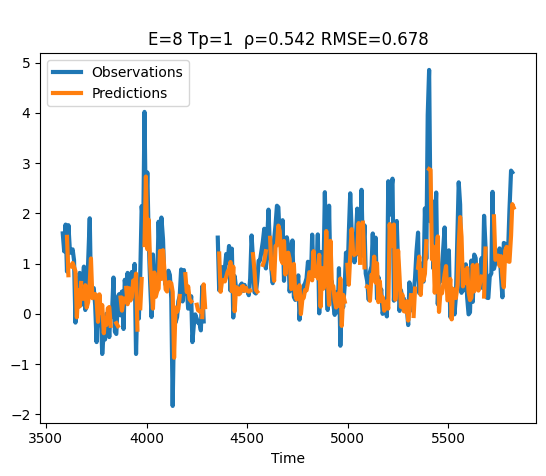

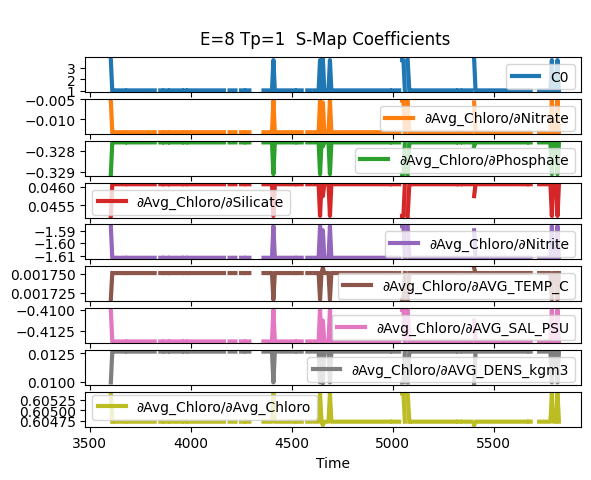

{'predictions':        Time  Observations  Predictions  Pred_Variance
0    3584.0      1.601406          NaN            NaN
1    3591.0      1.244155     1.394116       1.254111
2    3598.0      1.776646          NaN            NaN
3    3605.0      0.841567     1.532332       1.511415
4    3612.0      1.764731     0.768540       0.563624
..      ...           ...          ...            ...
316  5796.0      1.220830     1.045447       0.772714
317  5803.0      2.056685     1.035673       0.762723
318  5811.0      2.850707     1.559472       1.567410
319  5817.0      2.816007     2.183199       3.239775
320  5824.0           NaN     2.114673       3.019400

[321 rows x 4 columns], 'coefficients':        Time        C0  ∂Avg_Chloro/∂Nitrate  ∂Avg_Chloro/∂Phosphate  \
0    3584.0       NaN                   NaN                     NaN   
1    3591.0  1.041770             -0.013231               -0.327613   
2    3598.0       NaN                   NaN                     NaN   
3    3605.0

Time             5698.000000
Nitrate             0.780000
Phosphate           0.290000
Silicate            2.400000
Nitrite             0.000000
AVG_TEMP_C               NaN
AVG_SAL_PSU              NaN
AVG_DENS_kgm3            NaN
Avg_Chloro          0.314811
Name: 5698, dtype: float64

In [9]:
#Using embeddings 
#multiview embedding hao ye and sugihara (around 2015)
#t
'''
result = edm.SMap(
    dataFrame = embedded, 
    columns = 'Nitrate(t-0) Phosphate(t-0) Silicate(t-0) Nitrite(t-0) AVG_TEMP_C(t-0) AVG_SAL_PSU(t-0) AVG_DENS_kgm3(t-0) Avg_Chloro(t-0)',
    target = 'Avg_Chloro(t-0)',
    lib = '1 701',  # Library from rows 0 to 700
    pred = '702 832',
    E = 8,
    theta=2,
    showPlot = True,
    embedded=True,
    ignoreNan = True
)
print(result)
time_series.iloc[814]
'''


result = edm.SMap(
    dataFrame = time_series, 
    columns = 'Nitrate Phosphate Silicate Nitrite AVG_TEMP_C AVG_SAL_PSU AVG_DENS_kgm3 Avg_Chloro',
    target = 'Avg_Chloro',
    lib = '1 512',  # Library from rows 0 to 700
    pred = '513 832',
    E = 8,
    theta=0,
    tau = -3,
    showPlot = True,
    embedded=True,
    ignoreNan = True
)
print(result)
time_series.iloc[814]

In [10]:
result['predictions']


Time  Observations  Predictions  Pred_Variance
0    3584.0      1.601406          NaN            NaN
1    3591.0      1.244155     1.394116       1.254111
2    3598.0      1.776646          NaN            NaN
3    3605.0      0.841567     1.532332       1.511415
4    3612.0      1.764731     0.768540       0.563624
..      ...           ...          ...            ...
316  5796.0      1.220830     1.045447       0.772714
317  5803.0      2.056685     1.035673       0.762723
318  5811.0      2.850707     1.559472       1.567410
319  5817.0      2.816007     2.183199       3.239775
320  5824.0           NaN     2.114673       3.019400

[321 rows x 4 columns]

In [11]:
bloom_binary_prediction(result['predictions']['Observations'].iloc[1:-1],result['predictions']['Predictions'].iloc[1:-1])


/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


[1.0, nan, 0.0, 1.0, nan]

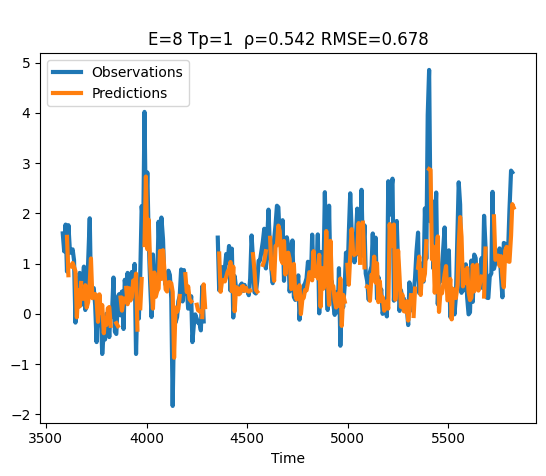

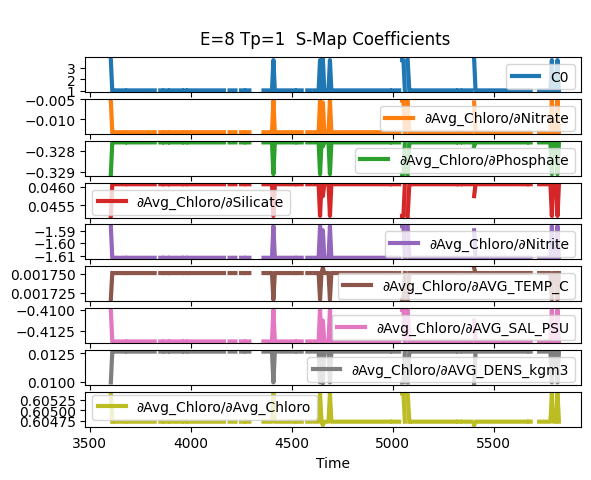

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


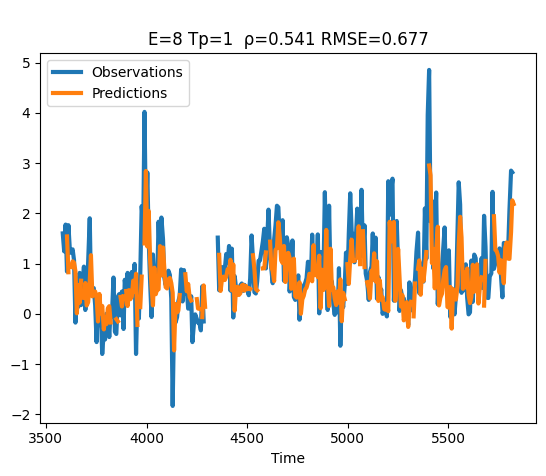

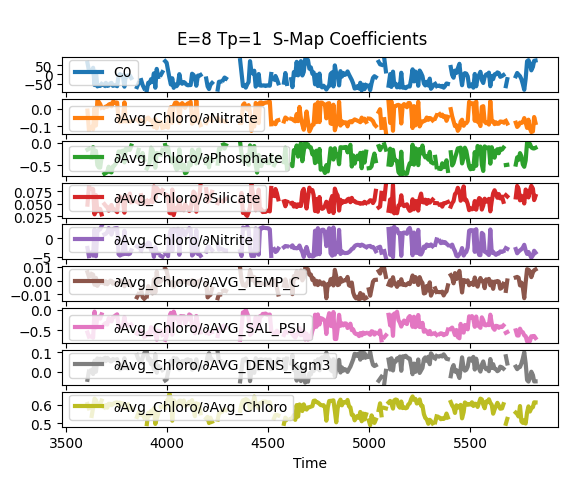

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


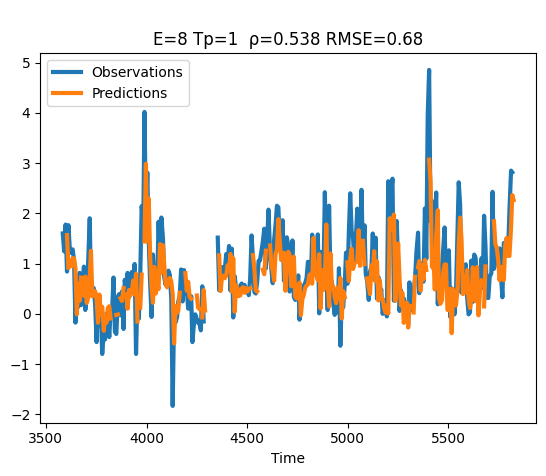

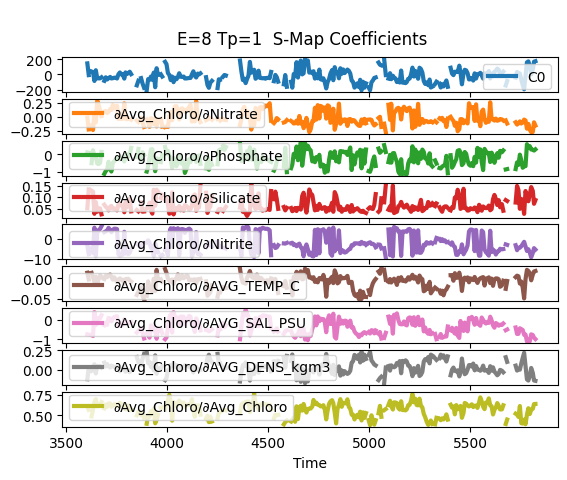

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


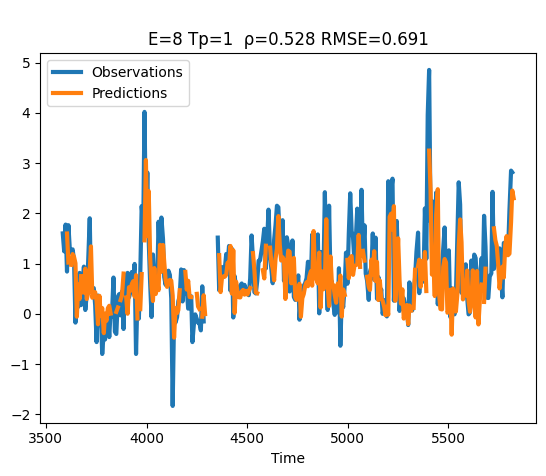

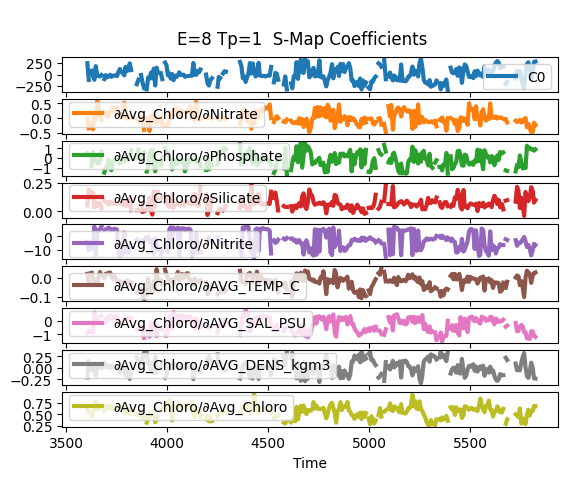

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


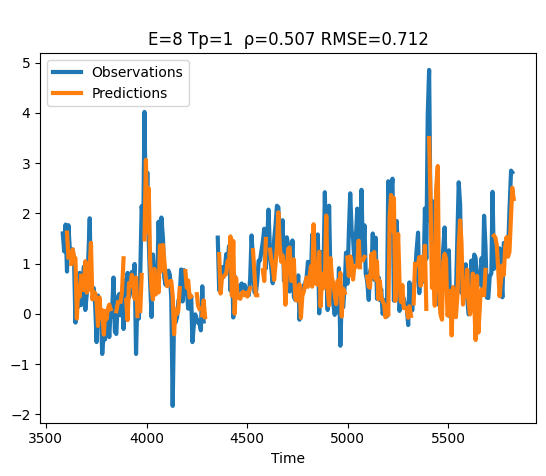

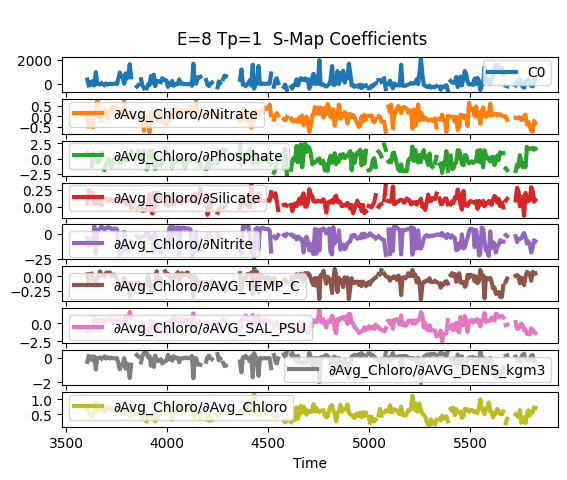

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


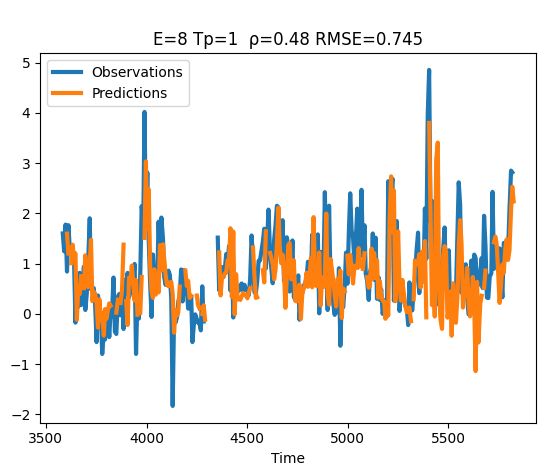

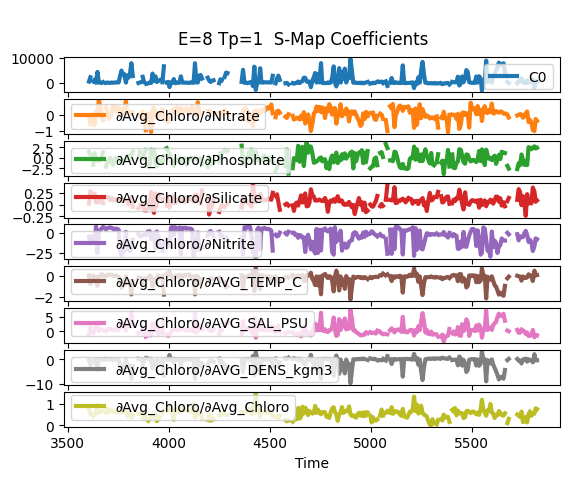

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


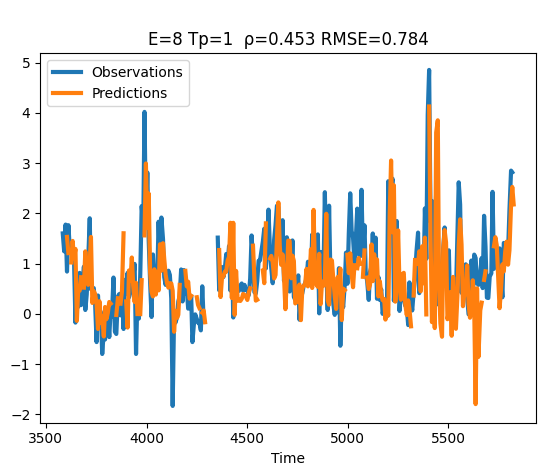

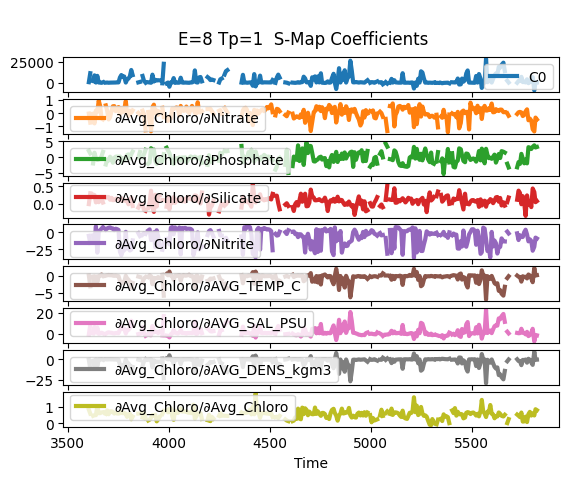

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


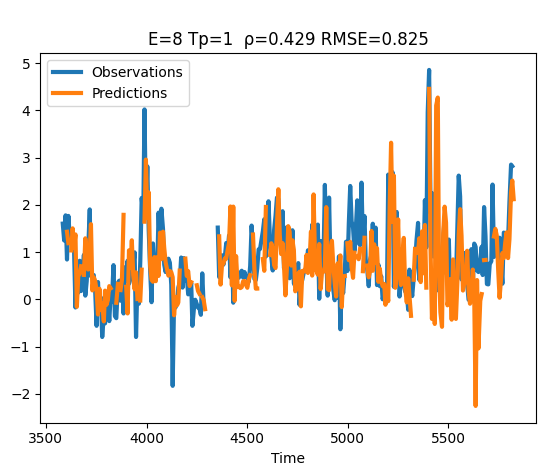

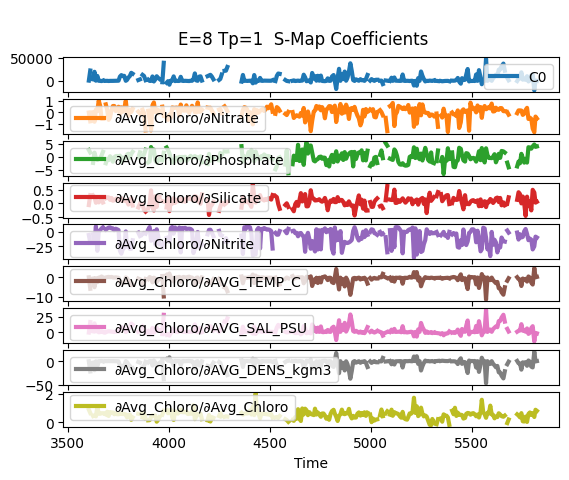

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


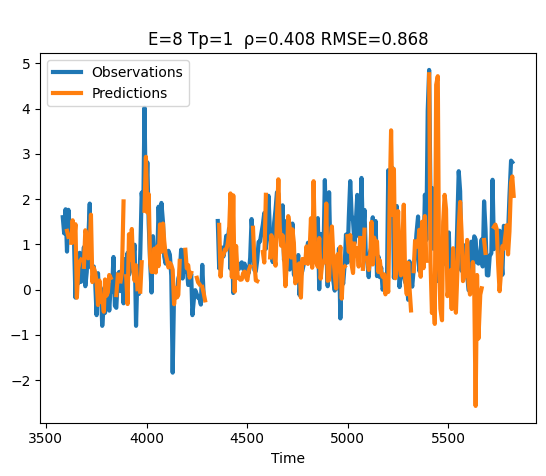

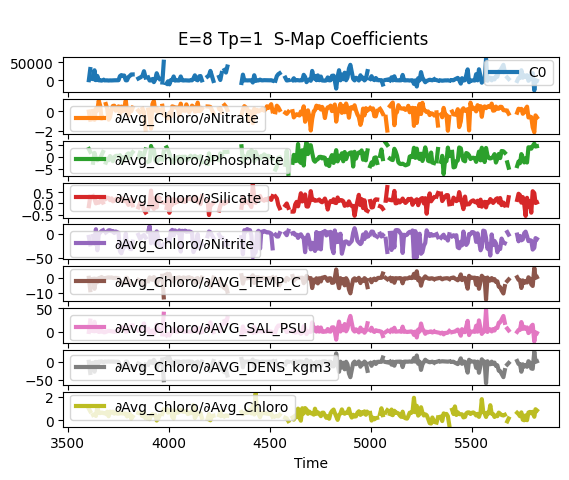

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


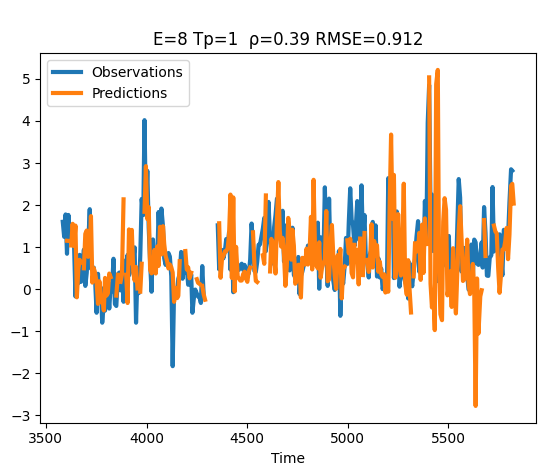

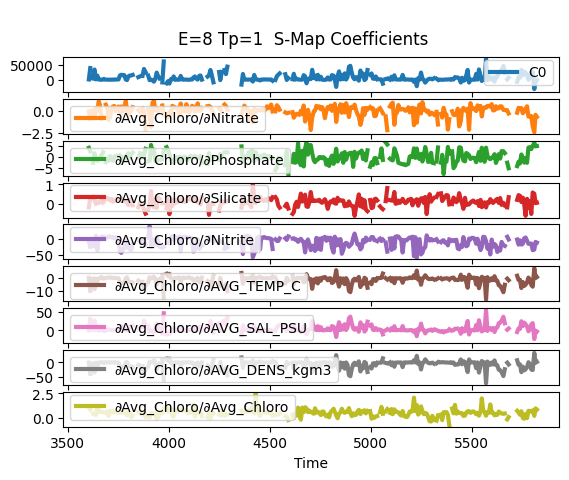

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


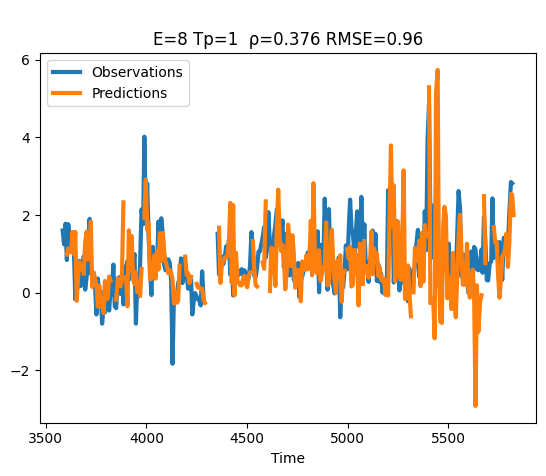

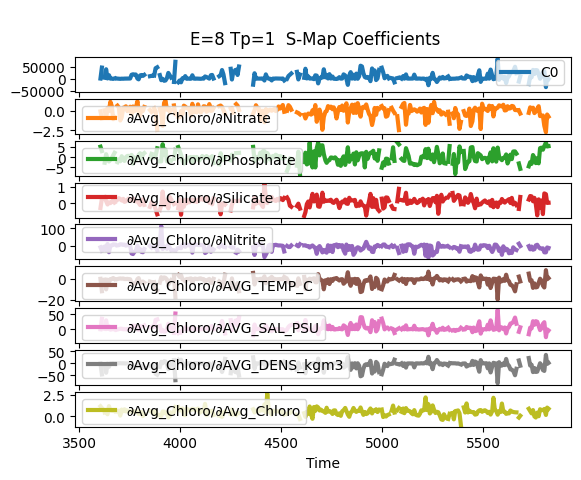

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:14: RuntimeWarning: invalid value encountered in scalar divide
  True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_64404/3949527838.py:17: RuntimeWarning: invalid value encountered in scalar divide
  False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()


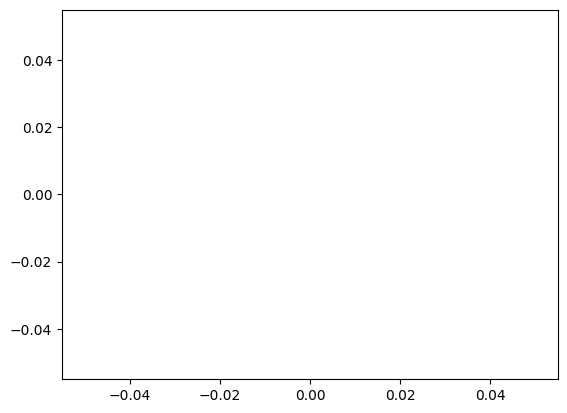

In [12]:
#Larger trial with different embeddings 
x = []
y = []
for i in range(0,11):
    result = edm.SMap(
    dataFrame = time_series, 
    columns = 'Nitrate Phosphate Silicate Nitrite AVG_TEMP_C AVG_SAL_PSU AVG_DENS_kgm3 Avg_Chloro',
    target = 'Avg_Chloro',
    lib = '1 512',  # Library from rows 0 to 700
    pred = '513 832',
    E = 8,
    tau=-1,
    theta=i,
    showPlot = True,
    embedded=True,
    ignoreNan = True
    )   
    cur_bloom = bloom_binary_prediction(result['predictions']['Observations'].iloc[1:-1],result['predictions']['Predictions'].iloc[1:-1])
    x.append(cur_bloom[2]) #False positive
    y.append(cur_bloom[1]) #True positive

plt.scatter(x, y, color='blue', label='Data Points')

In [13]:
result['predictions']['Observations'].iloc[1:]

1      1.244155
2      1.776646
3      0.841567
4      1.764731
5      1.214913
         ...   
316    1.220830
317    2.056685
318    2.850707
319    2.816007
320         NaN
Name: Observations, Length: 320, dtype: float64

In [14]:
time_series

Time  Nitrate  Phosphate  Silicate  Nitrite  AVG_TEMP_C  AVG_SAL_PSU  \
time                                                                         
0        0     0.43       0.24       5.6     0.03       18.10       33.695   
7        7     0.83       0.37       5.1     0.04       17.35       33.640   
13      13     0.45       0.24       3.5     0.00       20.25       33.660   
20      20     0.34       0.17       4.2     0.00        9.90       33.650   
28      28     0.29       0.12       3.8     0.00       11.25       33.710   
...    ...      ...        ...       ...      ...         ...          ...   
5789  5789     0.85       0.30       6.2     0.00       17.40       33.470   
5796  5796     0.45       0.25       4.9     0.00       17.90       33.475   
5803  5803     0.00       0.17       5.2     0.00       17.35       33.545   
5811  5811     0.00       0.20       9.4     0.00       17.70       33.625   
5817  5817     0.00       0.10       7.5     0.00       17.80       33.625   

      AVG_DENS_kgm3  Avg_Chloro  
time                             
0       1024.129374    0.598837  
7       1024.289049    0.996949  
13      1023.563298   -0.010050  
20      1023.740812    0.207014  
28      1023.004896    0.879627  
...             ...         ...  
5789    1024.149572    1.169381  
5796    1024.033476    1.220830  
5803    1024.214172    2.056685  
5811    1024.194573    2.850707  
5817    1024.169303    2.816007  

[832 rows x 9 columns]

In [15]:
y

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

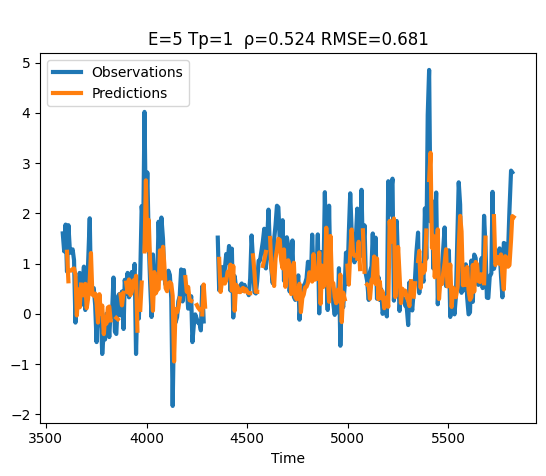

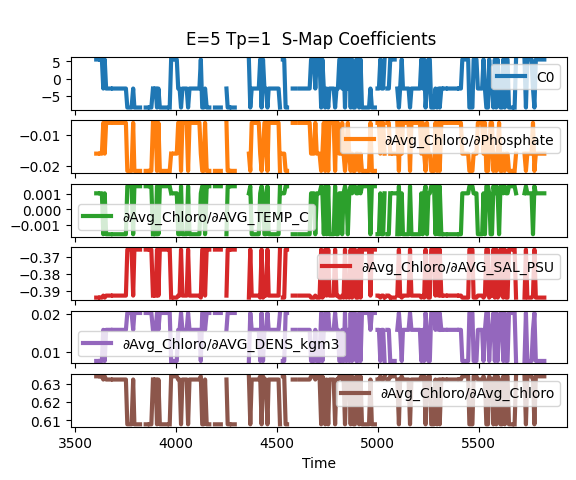

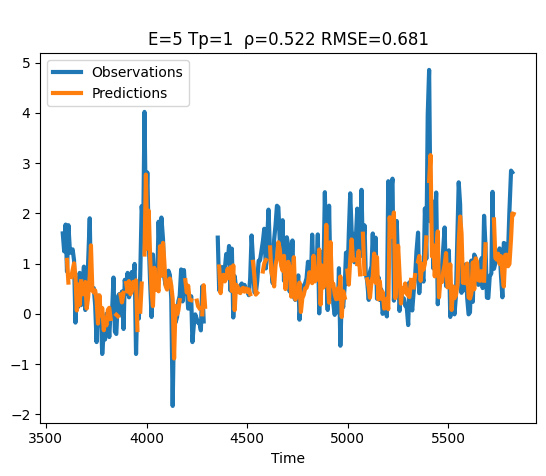

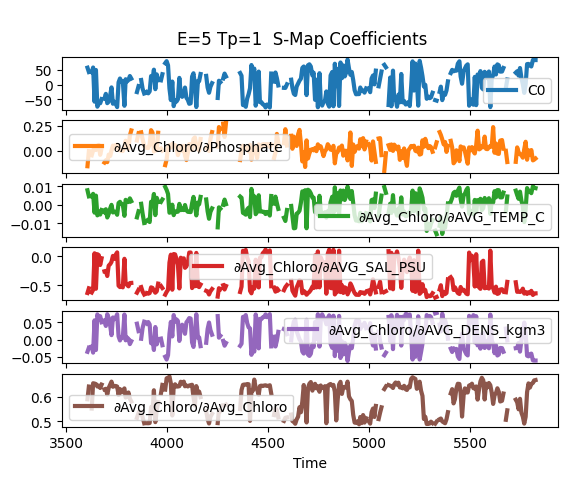

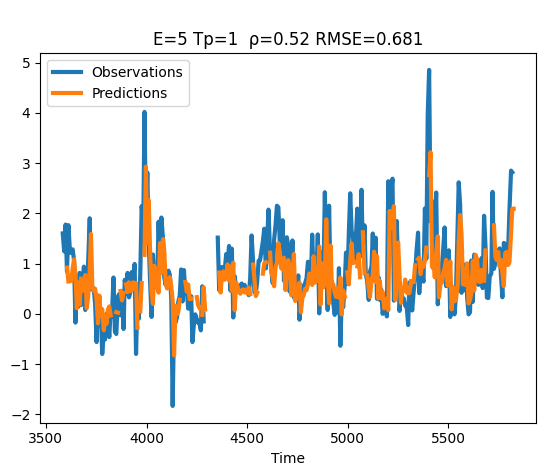

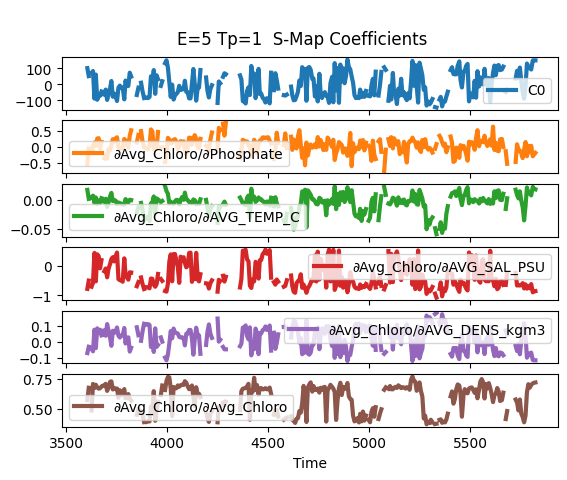

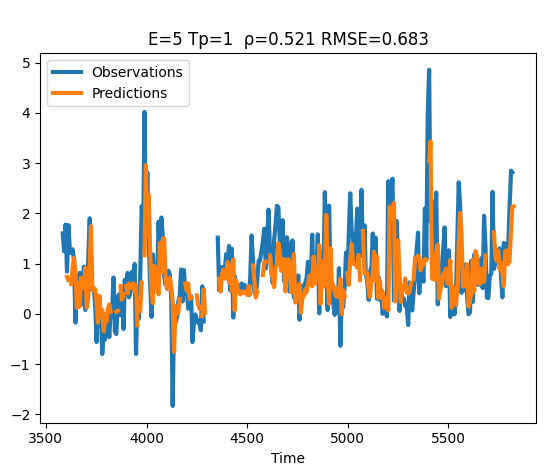

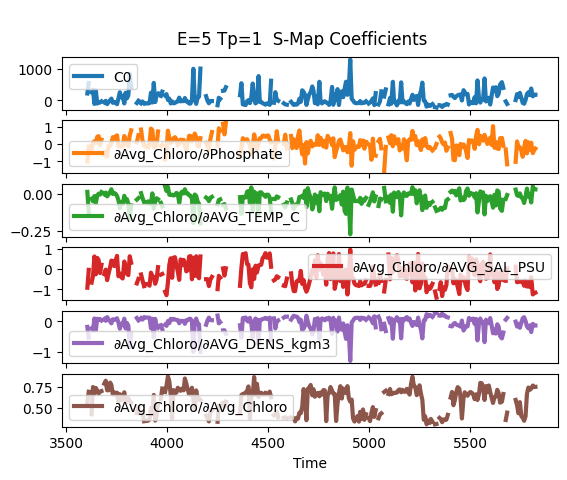

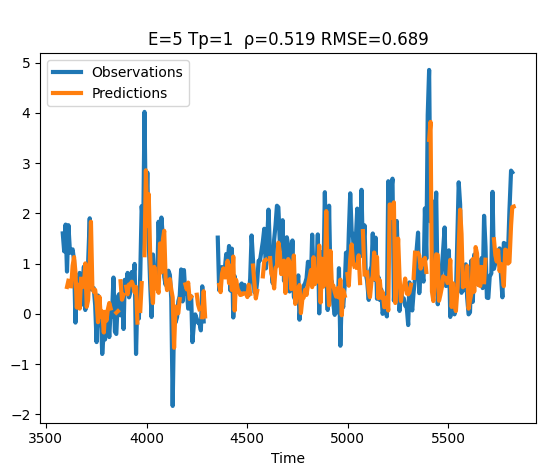

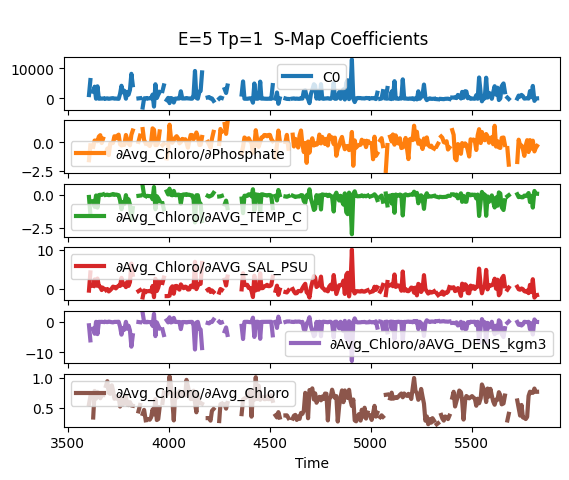

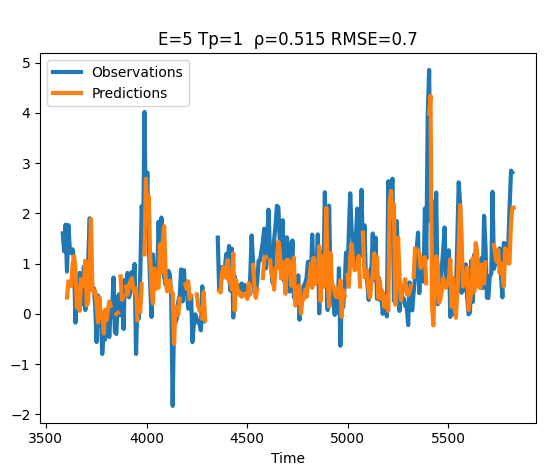

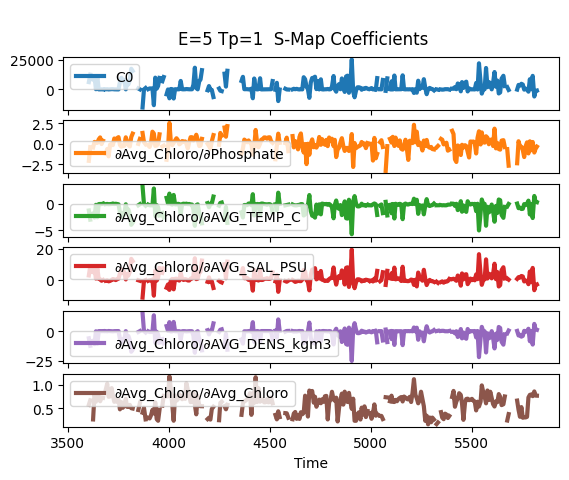

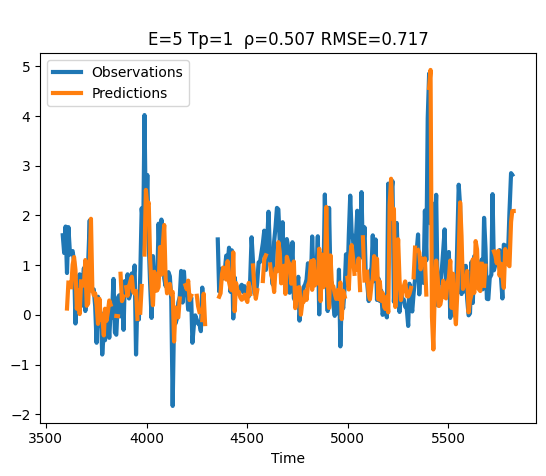

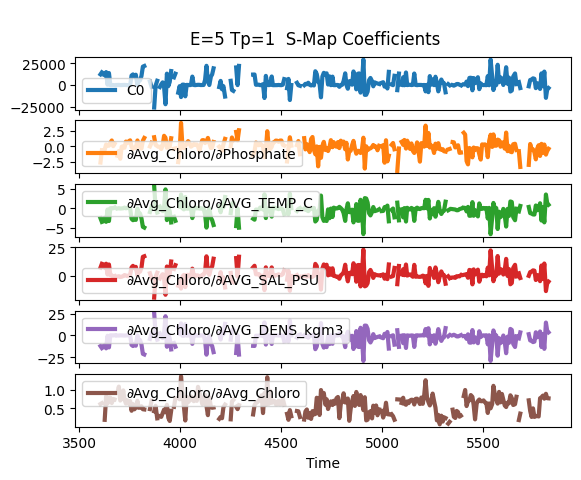

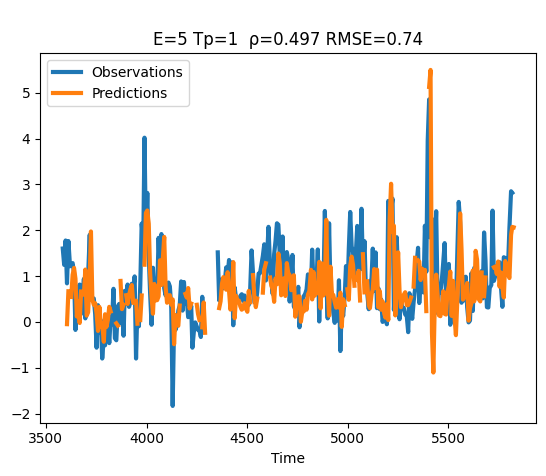

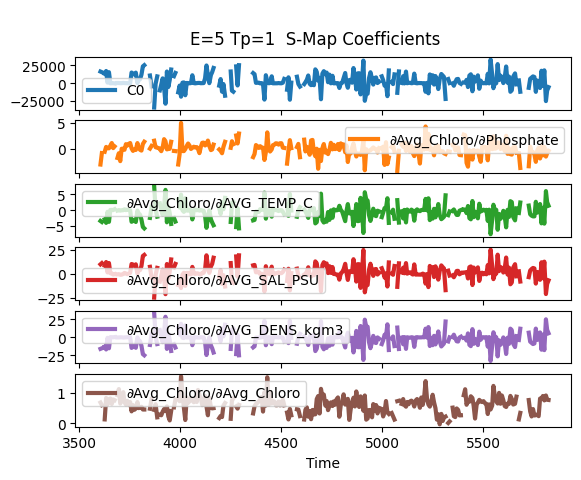

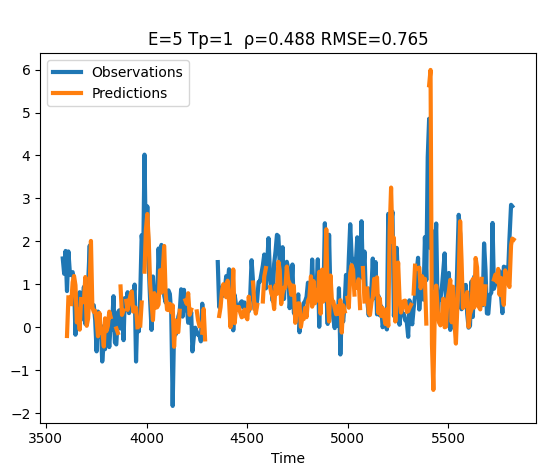

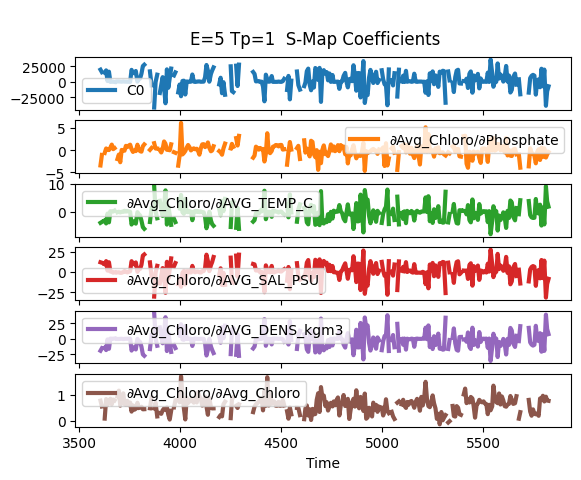

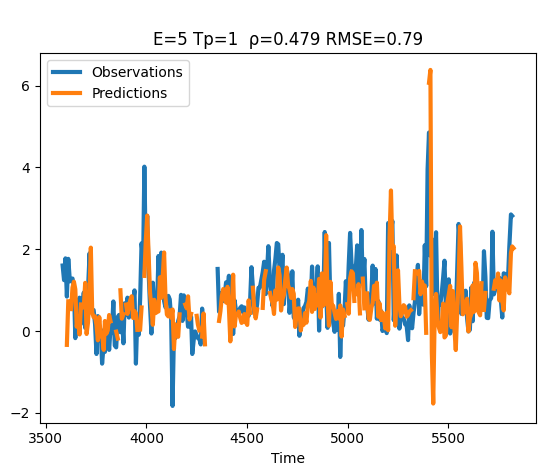

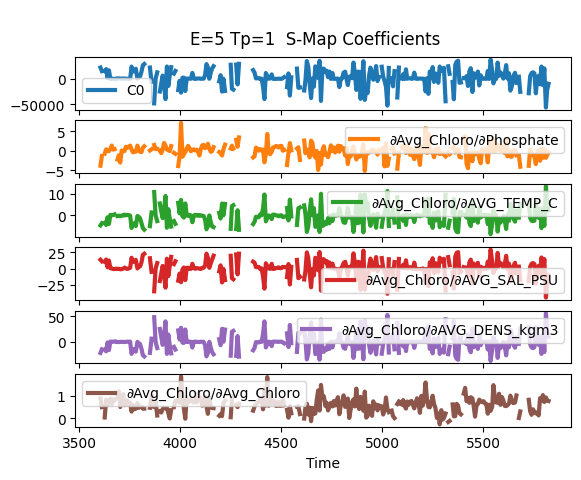

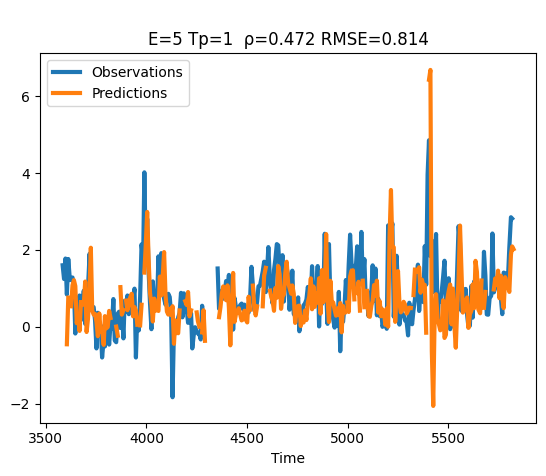

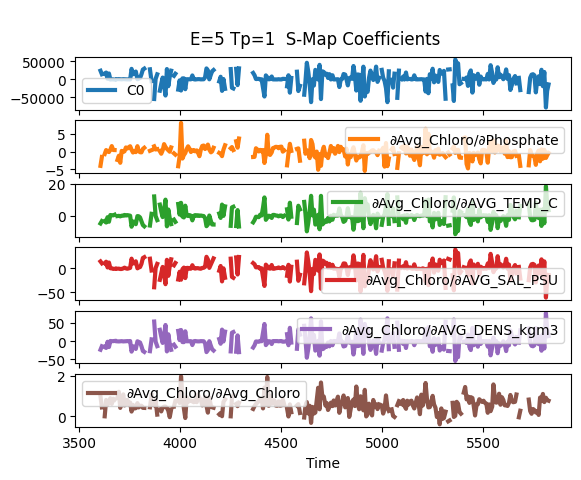

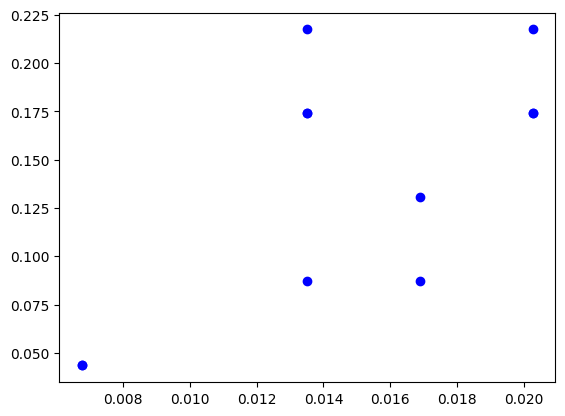

In [16]:
#Larger trial with different embeddings 
x = []
y = []
for i in range(0,11):
    result = edm.SMap(
    dataFrame = time_series, 
    columns = 'Phosphate AVG_TEMP_C AVG_SAL_PSU AVG_DENS_kgm3 Avg_Chloro',
    target = 'Avg_Chloro',
    lib = '1 512',  # Library from rows 0 to 700
    pred = '513 832',
    E = 8,
    tau=-1,
    theta=i,
    showPlot = True,
    embedded=True,
    ignoreNan = True
    )   
    cur_bloom = thresh_bloom_binary_prediction(result['predictions']['Observations'].iloc[1:-1],result['predictions']['Predictions'].iloc[1:-1],threshold=np.log(8.03199999999999))
    x.append(cur_bloom[2]) #False positive
    y.append(cur_bloom[1]) #True positive

plt.scatter(x, y, color='blue', label='Data Points')

# Test with data transformations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
from itertools import permutations
from itertools import combinations
from pyEDM import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
import time
import os
from copy import deepcopy
import math
import random
from sklearn.metrics import root_mean_squared_error
from scipy.stats import ttest_ind
import pickle


from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

import warnings
warnings.filterwarnings("ignore", 
    message="A worker stopped while some jobs were given to the executor.",
    module="joblib.externals.loky.process_executor")

In [2]:
'''
Binary prediction skill (“bloom” or “no bloom”) is
evaluated by how well bloom predictions (5% largest predicted values)
correspond to bloom observations (5%largest observed values)
Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
'''
def bloom_binary_prediction(obs,pred):
    obs_bloom_95 = np.percentile(obs, 95) #incorrect
    pred_bloom_95 = np.percentile(pred, 95) #incorrect
    obs_blooms = obs > obs_bloom_95
    pred_blooms = pred > pred_bloom_95
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]


'''
Binary prediction skill (“bloom” or “no bloom”) is
evaluated by how well bloom predictions above a defined threshold
correspond to bloom observations above the same threshold
Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
'''
def thresh_bloom_binary_prediction(obs,pred,threshold=8.03199999999999):
    #obs_bloom_95 = np.percentile(obs, 95) #incorrect
    #pred_bloom_95 = np.percentile(pred, 95) #incorrect
    obs_blooms = obs > threshold
    pred_blooms = pred > threshold
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]

In [3]:
def get_block(data, num_lags=1, tau=1):
    ''' Get a dataframe with all the possible valid lags of the variables. '''
    
    block = pd.concat([data[var].shift(lag*tau).rename(f'{var}(t-{lag*tau})') for lag in range(num_lags+1) for var in data.columns], axis=1)

    return block
def get_xmap_results_smap(block, target, embeddings, Tp, theta, lib, pred):
    '''Function to do exhaustive search of embeddings.'''
    
    def compute_rho(block, target, embedding, Tp, theta, lib, pred):
        xmap = SMap(dataFrame=block, target=target, columns=embedding, Tp=Tp, theta=theta, embedded=True, lib=lib, pred=pred, noTime=True)
        rho = xmap['predictions'][['Observations', 'Predictions']].corr().iloc[0,1]
        return embedding, xmap['predictions'], rho

    xmap_results = pd.DataFrame(columns=['embedding', 'rho'])
    xmap_results = Parallel(n_jobs=-1)(delayed(compute_rho)(block, target, embedding, Tp, theta, lib, pred) for embedding in embeddings)
    xmap_results = pd.DataFrame(xmap_results, columns=['embedding', 'result', 'rho'])
    xmap_results = xmap_results.sort_values(by='rho', ascending=False).reset_index(drop=True)
    
    return xmap_results

In [4]:

paper_data = pd.read_csv('Data/data_w_gaps_and_wind.csv')
paper_data = paper_data.set_index('time')
paper_data['Time'] = paper_data.index.astype(int)
paper_data['Avg_Chloro'] = paper_data['Avg_Chloro'].apply(np.log1p)
#IMPUTE HAB DATA
#Build basic linear regression model as sanity check
# Custom impute missing values with the average of the value in front and behind of it 
class ForwardBackwardImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
        X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')

        return (X_filled_forward + X_filled_backward) / 2


Imputer = ForwardBackwardImputer()
paper_data = paper_data.apply(pd.to_numeric, errors='coerce')
Imputer.fit(paper_data)
paper_data = Imputer.transform(paper_data)#COMMENT OUT IF DONT WANT MEAN MPUTE
paper_data
HAB_embed = get_block(paper_data,50)
paper_data

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_78128/2242177190.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_78128/2242177190.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')


Avg_Chloro  Nitrate  Phosphate  Silicate  Nitrite  SURF_TEMP_C  \
time                                                                   
0       1.036737     0.43       0.24       5.6     0.03         20.3   
7       1.311032     0.83       0.37       5.1     0.04         17.8   
13      0.688135     0.45       0.24       3.5     0.00         22.2   
20      0.802002     0.34       0.17       4.2     0.00         19.8   
28      1.226712     0.29       0.12       3.8     0.00         22.5   
...          ...      ...        ...       ...      ...          ...   
5789    1.439835     0.85       0.30       6.2     0.00         17.4   
5796    1.479329     0.45       0.25       4.9     0.00         17.9   
5803    2.177022     0.00       0.17       5.2     0.00         18.3   
5811    2.906901     0.00       0.20       9.4     0.00         18.0   
5817    2.874129     0.00       0.10       7.5     0.00         18.4   

      BOT_TEMP_C  SURF_SAL_PSU  BOT_SAL_PSU  SURF_DENS_kgm3  BOT_DENS_kgm3  \
time                                                                         
0           15.9         33.77        33.62     1023.638094    1024.620655   
7           16.9         33.66        33.62     1024.186379    1024.391719   
13          18.3         33.74        33.58     1023.100557    1024.026040   
20          19.4         33.68        33.62     1023.701088    1023.780535   
28          22.5         33.73        33.69     1023.009067    1023.000725   
...          ...           ...          ...             ...            ...   
5789        17.4         33.48        33.46     1024.146195    1024.152950   
5796        17.9         33.48        33.47     1024.026335    1024.040616   
5803        16.4         33.54        33.55     1023.974093    1024.454252   
5811        17.4         33.64        33.61     1024.122823    1024.266323   
5817        17.2         33.63        33.62     1024.017322    1024.321284   

      AVG_TEMP_C  AVG_SAL_PSU  AVG_DENS_kgm3      WSPD    Time  
time                                                            
0          18.10       33.695    1024.129374  4.691667     0.0  
7          17.35       33.640    1024.289049  2.787500     7.0  
13         20.25       33.660    1023.563298  3.412500    13.0  
20          9.90       33.650    1023.740812  3.495833    20.0  
28         11.25       33.710    1023.004896  2.604167    28.0  
...          ...          ...            ...       ...     ...  
5789       17.40       33.470    1024.149572  5.076389  5789.0  
5796       17.90       33.475    1024.033476  2.737500  5796.0  
5803       17.35       33.545    1024.214172  3.306250  5803.0  
5811       17.70       33.625    1024.194573  2.418056  5811.0  
5817       17.80       33.625    1024.169303  2.568056  5817.0  

[832 rows x 16 columns]

In [5]:
def get_valid_lags_tau(block, target, tau, num_lags, system_variables):
    
    # Get lags of system variables
    system_variable_lags = []
    for var in system_variables:
        # Get forwards and backwards lag of the system variables
        var_lags = [f'{var}(t{i})' if i < 0 else f'{var}(t-{i})' for i in range(num_lags * tau, 1)]
        var_lags = var_lags[::tau][:num_lags]
        system_variable_lags = system_variable_lags + var_lags
    
    # Remove (t-0) lag of target variable from valid_lags
    valid_lags = [x for x in system_variable_lags if x != f'{target}(t-0)']

                    
    return valid_lags
system_variables = ['AVG_SAL_PSU', 'Avg_Chloro', 'Nitrate', 'SURF_TEMP_C','BOT_DENS_kgm3']
target = 'Avg_Chloro'
system_variables = system_variables
Tp = 1
num_lags = 10   # Use -3, 0, and +3 lags of each variable
tau = -1

valid_lags = get_valid_lags_tau(HAB_embed, target, tau, num_lags, system_variables)
valid_lags

['AVG_SAL_PSU(t-0)',
 'AVG_SAL_PSU(t-1)',
 'AVG_SAL_PSU(t-2)',
 'AVG_SAL_PSU(t-3)',
 'AVG_SAL_PSU(t-4)',
 'AVG_SAL_PSU(t-5)',
 'AVG_SAL_PSU(t-6)',
 'AVG_SAL_PSU(t-7)',
 'AVG_SAL_PSU(t-8)',
 'AVG_SAL_PSU(t-9)',
 'Avg_Chloro(t-1)',
 'Avg_Chloro(t-2)',
 'Avg_Chloro(t-3)',
 'Avg_Chloro(t-4)',
 'Avg_Chloro(t-5)',
 'Avg_Chloro(t-6)',
 'Avg_Chloro(t-7)',
 'Avg_Chloro(t-8)',
 'Avg_Chloro(t-9)',
 'Nitrate(t-0)',
 'Nitrate(t-1)',
 'Nitrate(t-2)',
 'Nitrate(t-3)',
 'Nitrate(t-4)',
 'Nitrate(t-5)',
 'Nitrate(t-6)',
 'Nitrate(t-7)',
 'Nitrate(t-8)',
 'Nitrate(t-9)',
 'SURF_TEMP_C(t-0)',
 'SURF_TEMP_C(t-1)',
 'SURF_TEMP_C(t-2)',
 'SURF_TEMP_C(t-3)',
 'SURF_TEMP_C(t-4)',
 'SURF_TEMP_C(t-5)',
 'SURF_TEMP_C(t-6)',
 'SURF_TEMP_C(t-7)',
 'SURF_TEMP_C(t-8)',
 'SURF_TEMP_C(t-9)',
 'BOT_DENS_kgm3(t-0)',
 'BOT_DENS_kgm3(t-1)',
 'BOT_DENS_kgm3(t-2)',
 'BOT_DENS_kgm3(t-3)',
 'BOT_DENS_kgm3(t-4)',
 'BOT_DENS_kgm3(t-5)',
 'BOT_DENS_kgm3(t-6)',
 'BOT_DENS_kgm3(t-7)',
 'BOT_DENS_kgm3(t-8)',
 'BOT_DENS_kgm3(t-9)']

In [7]:
random_embeddings = {}
for E in range(3,16):
    # Get random embeddings using valid lags
    embeddings = set()
    sample = 100#20000#10000000
    max_trials = 100#200000#10000000
    trials = 0
    while len(embeddings) < sample and trials < max_trials:
        embedding = tuple(random.sample(valid_lags, E))
        sorted_embedding = tuple(sorted(embedding))
        if sorted_embedding not in embeddings:
            embeddings.add(sorted_embedding)
        trials += 1
    embeddings = [list(embedding) for embedding in embeddings]
    random_embeddings['{0}'.format((target, E))] = embeddings
    print(f'E = {E}, # embeddings = {len(embeddings)}')
    
with open('random_embeddings_HAB_pred.pkl', 'wb') as file:
     pickle.dump(random_embeddings, file)

E = 3, # embeddings = 100
E = 4, # embeddings = 100
E = 5, # embeddings = 100
E = 6, # embeddings = 100
E = 7, # embeddings = 100
E = 8, # embeddings = 100
E = 9, # embeddings = 100
E = 10, # embeddings = 100
E = 11, # embeddings = 100
E = 12, # embeddings = 100
E = 13, # embeddings = 100
E = 14, # embeddings = 100
E = 15, # embeddings = 100


In [9]:
# Load HAB random embeddings
with open('random_embeddings_HAB_pred.pkl', 'rb') as file:
    HAB_embeddings = pickle.load(file)
HAB_embeddings["('Avg_Chloro', 3)"][0]

['BOT_DENS_kgm3(t-9)', 'SURF_TEMP_C(t-8)', 'SURF_TEMP_C(t-9)']

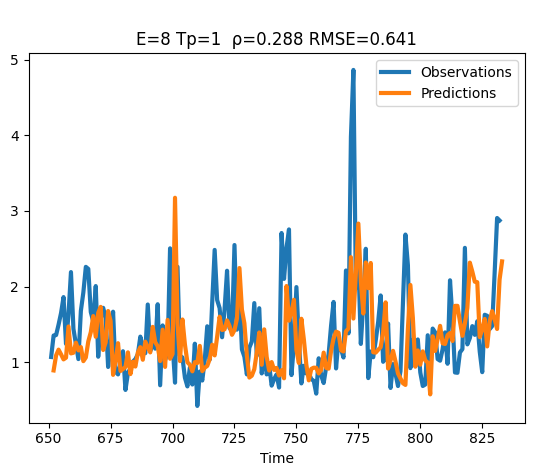

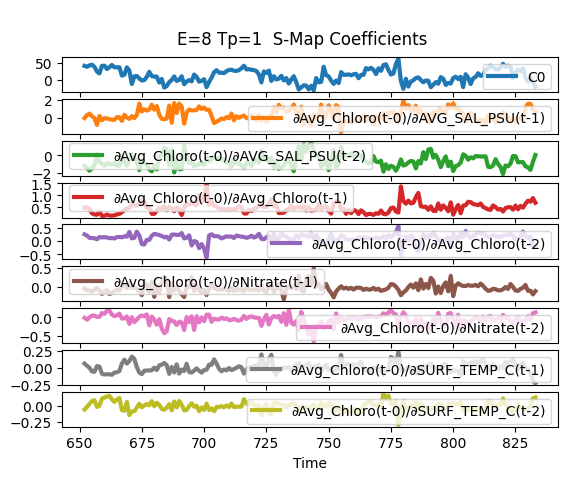

{'predictions':       Time  Observations  Predictions  Pred_Variance
 0    651.0      1.071584          NaN            NaN
 1    652.0      1.355835     0.893965       0.249445
 2    653.0      1.360977     1.092348       0.242555
 3    654.0      1.499623     1.168471       0.262005
 4    655.0      1.652497     1.106660       0.256279
 ..     ...           ...          ...            ...
 178  829.0      1.479329     1.676963       0.615115
 179  830.0      2.177022     1.569760       0.516752
 180  831.0      2.906901     1.441593       0.414647
 181  832.0      2.874129     2.094125       1.267899
 182  833.0           NaN     2.333925       1.677569
 
 [183 rows x 4 columns],
 'coefficients':       Time         C0  ∂Avg_Chloro(t-0)/∂AVG_SAL_PSU(t-1)  \
 0    651.0        NaN                                 NaN   
 1    652.0  41.375633                           -0.047334   
 2    653.0  38.775427                            0.293075   
 3    654.0  42.792543                        

In [10]:
def create_edm_model_standard_embed(E,theta,tau,target,columns,lib='1 532', pred='533 832',showPlot=True):
    A = target
    B = columns
    driver = f'{A}(t-0)'
    pred_cols = []
    for col in B:
        driven_embedded = [f'{col}(t{i})' if i < 0 else f'{col}(t-{i})' for i in range(E * tau, 1)]
        driven_embedded = driven_embedded[::tau][1:E]
        pred_cols.extend(driven_embedded)
    result = SMap(
        dataFrame = HAB_embed, 
        columns = pred_cols,
        target = driver,
        lib = lib,  # Library from rows 0 to 700
        pred = pred,
        E = E,
        theta=theta,
        tau = tau,
        noTime=True,
        showPlot = showPlot,
        embedded=True,
        ignoreNan = True
    )
    return result

E = 3
theta = 5
tau = -1
target = 'Avg_Chloro'
columns = ['AVG_SAL_PSU', 'Avg_Chloro', 'Nitrate', 'SURF_TEMP_C']
lib = '1 650'  # Library from rows 0 to 700
pred = '651 832'
create_edm_model_standard_embed(E,theta,tau,target,columns,lib,pred)

['BOT_DENS_kgm3(t-9)', 'SURF_TEMP_C(t-8)', 'SURF_TEMP_C(t-9)']


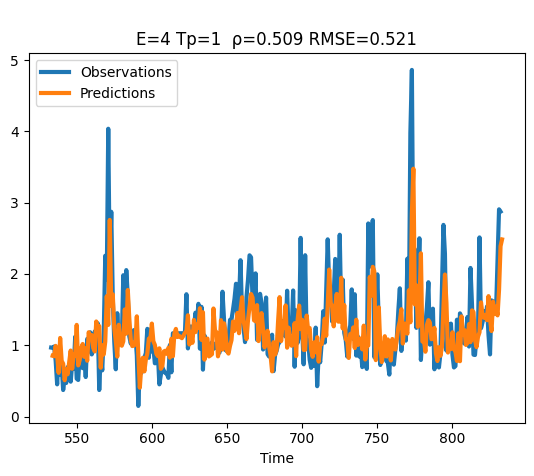

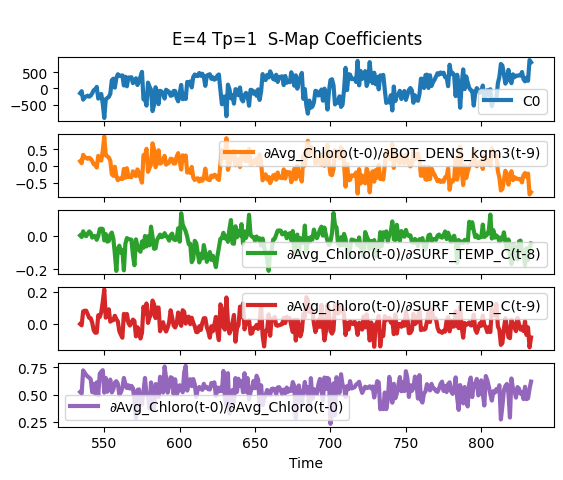

In [13]:
def create_edm_model(E,theta,target,i_cols,lib='1 532', pred='533 832',showPlot=True):
    driver = f'{target}(t-0)'
    cols = i_cols + [driver]
    result = SMap(
        dataFrame = HAB_embed, 
        columns = cols,
        target = driver,
        lib = lib,  # Library from rows 0 to 700
        pred = pred,
        E = E+1,
        theta=theta,
        noTime=True,
        showPlot = showPlot,
        embedded=True,
        ignoreNan = True
    )
    return result

E = 3
theta = 5
target = 'Avg_Chloro'
columns = HAB_embeddings["('Avg_Chloro', 3)"][0]
lib = '1 650'  # Library from rows 0 to 700
print(columns)
pred = '651 832'
modl = create_edm_model(E,theta,target,columns,lib='1 532', pred='533 832',showPlot=True)

In [23]:
#Create models using extensive search 
# Save HAB cross-mapping results
E_list = range(4,16)
theta_list = [1,5,9,15,25,35,45]
lib = '1 532'  # Library from rows 0 to 700
pred = '533 832'

total_iterations = len(E_list) * len(theta_list)

results = {}
parameters = pd.DataFrame(columns=['target', 'columns', 'E', 'theta', 'rho', 'rmse', 'bbp', 'pred'])
block = HAB_embed

with tqdm(total=total_iterations) as pbar:
    for E, theta in product(E_list, theta_list):

        key = [key for key in HAB_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E] #HAB_embeddings["('Avg_Chloro', 4, 0, 6)"][0]
        embeddings = HAB_embeddings[key[0]]
        for embedding in embeddings:
            smap_model = create_edm_model(E,theta,target,embedding,lib=lib, pred=pred,showPlot=False)
            df = smap_model['predictions']
            rho = df[['Observations', 'Predictions']].corr().iloc[0,1]
            rmse = root_mean_squared_error(df['Observations'].iloc[1:-1], df['Predictions'].iloc[1:-1])
            bbp = bloom_binary_prediction(df['Observations'].iloc[1:-1],df['Predictions'].iloc[1:-1])

            new_row = {'target': target, 'columns': embedding + [f'{target} (t-0)'], 'E': E,'theta':theta, 'rho':rho, 'rmse':rmse, 'bbp':bbp, 'pred':df['Predictions']}
            parameters.loc[len(parameters)] = new_row

        

        pbar.update(1)
parameters

100%|██████████| 84/84 [09:08<00:00,  6.53s/it]


target                                            columns   E  \
0     Avg_Chloro  [Avg_Chloro(t-9), Nitrate(t-3), SURF_TEMP_C(t-...   4   
1     Avg_Chloro  [AVG_SAL_PSU(t-5), Avg_Chloro(t-1), BOT_DENS_k...   4   
2     Avg_Chloro  [AVG_SAL_PSU(t-5), AVG_SAL_PSU(t-8), Avg_Chlor...   4   
3     Avg_Chloro  [AVG_SAL_PSU(t-1), AVG_SAL_PSU(t-7), Nitrate(t...   4   
4     Avg_Chloro  [AVG_SAL_PSU(t-4), BOT_DENS_kgm3(t-9), Nitrate...   4   
...          ...                                                ...  ..   
8395  Avg_Chloro  [AVG_SAL_PSU(t-0), AVG_SAL_PSU(t-4), AVG_SAL_P...  15   
8396  Avg_Chloro  [AVG_SAL_PSU(t-1), AVG_SAL_PSU(t-2), AVG_SAL_P...  15   
8397  Avg_Chloro  [AVG_SAL_PSU(t-1), AVG_SAL_PSU(t-3), AVG_SAL_P...  15   
8398  Avg_Chloro  [AVG_SAL_PSU(t-0), AVG_SAL_PSU(t-2), AVG_SAL_P...  15   
8399  Avg_Chloro  [AVG_SAL_PSU(t-0), AVG_SAL_PSU(t-1), AVG_SAL_P...  15   

      theta       rho      rmse  \
0         1  0.528132  0.511145   
1         1  0.553341  0.502680   
2         1  0.538994  0.509303   
3         1  0.526017  0.516667   
4         1  0.531707  0.516143   
...     ...       ...       ...   
8395     45  0.134197  1.245905   
8396     45  0.082151  1.289138   
8397     45  0.078991  1.183936   
8398     45  0.264394  1.127127   
8399     45  0.009335  1.315412   

                                                    bbp  \
0     [0.9130434782608696, 0.13333333333333333, 0.04...   
1     [0.9264214046822743, 0.26666666666666666, 0.03...   
2     [0.9331103678929766, 0.3333333333333333, 0.035...   
3     [0.919732441471572, 0.2, 0.04225352112676056, ...   
4     [0.919732441471572, 0.2, 0.04225352112676056, ...   
...                                                 ...   
8395  [0.9063545150501673, 0.06666666666666667, 0.04...   
8396  [0.919732441471572, 0.2, 0.04225352112676056, ...   
8397  [0.8996655518394648, 0.0, 0.0528169014084507, ...   
8398  [0.9264214046822743, 0.26666666666666666, 0.03...   
8399  [0.8996655518394648, 0.0, 0.0528169014084507, ...   

                                                   pred  
0     0           NaN
1      0.851575
2      0.86643...  
1     0           NaN
1      1.150059
2      0.95467...  
2     0           NaN
1      0.981400
2      1.04484...  
3     0           NaN
1      0.979796
2      0.96276...  
4     0           NaN
1      0.863772
2      0.86876...  
...                                                 ...  
8395  0           NaN
1      0.716972
2      0.60428...  
8396  0           NaN
1      0.694340
2      0.77320...  
8397  0           NaN
1      1.907980
2      0.29974...  
8398  0           NaN
1      2.272300
2      0.11015...  
8399  0           NaN
1      2.971928
2      2.71948...  

[8400 rows x 8 columns]

In [24]:
#look into parameters
parameters.sort_values(by='rho',ascending=False)
parameters.assign(TP = parameters['bbp'].apply(lambda x: x[1])).sort_values(by='TP',ascending=False)

target                                            columns   E  \
4130  Avg_Chloro  [AVG_SAL_PSU(t-1), AVG_SAL_PSU(t-2), AVG_SAL_P...   9   
2918  Avg_Chloro  [AVG_SAL_PSU(t-1), AVG_SAL_PSU(t-4), AVG_SAL_P...   8   
3118  Avg_Chloro  [AVG_SAL_PSU(t-1), AVG_SAL_PSU(t-4), AVG_SAL_P...   8   
1921  Avg_Chloro  [AVG_SAL_PSU(t-7), AVG_SAL_PSU(t-9), Avg_Chlor...   6   
2988  Avg_Chloro  [AVG_SAL_PSU(t-0), AVG_SAL_PSU(t-5), AVG_SAL_P...   8   
...          ...                                                ...  ..   
2684  Avg_Chloro  [AVG_SAL_PSU(t-6), Avg_Chloro(t-7), Avg_Chloro...   7   
2671  Avg_Chloro  [AVG_SAL_PSU(t-3), Avg_Chloro(t-9), BOT_DENS_k...   7   
2656  Avg_Chloro  [AVG_SAL_PSU(t-2), AVG_SAL_PSU(t-4), Avg_Chlor...   7   
2637  Avg_Chloro  [Avg_Chloro(t-4), BOT_DENS_kgm3(t-0), Nitrate(...   7   
8399  Avg_Chloro  [AVG_SAL_PSU(t-0), AVG_SAL_PSU(t-1), AVG_SAL_P...  15   

      theta       rho      rmse  \
4130     45  0.387759  1.314850   
2918      5  0.525334  0.522384   
3118     15  0.338261  0.745372   
1921     35  0.266020  1.430131   
2988      5  0.510771  0.523881   
...     ...       ...       ...   
2684     35  0.157524  1.102042   
2671     35  0.115942  1.055578   
2656     35  0.221870  0.874959   
2637     35  0.142970  0.923318   
8399     45  0.009335  1.315412   

                                                    bbp  \
4130  [0.9464882943143813, 0.4666666666666667, 0.028...   
2918  [0.939799331103679, 0.4, 0.03169014084507042, ...   
3118  [0.939799331103679, 0.4, 0.03169014084507042, ...   
1921  [0.939799331103679, 0.4, 0.03169014084507042, ...   
2988  [0.939799331103679, 0.4, 0.03169014084507042, ...   
...                                                 ...   
2684  [0.8996655518394648, 0.0, 0.0528169014084507, ...   
2671  [0.8996655518394648, 0.0, 0.0528169014084507, ...   
2656  [0.8996655518394648, 0.0, 0.0528169014084507, ...   
2637  [0.8996655518394648, 0.0, 0.0528169014084507, ...   
8399  [0.8996655518394648, 0.0, 0.0528169014084507, ...   

                                                   pred        TP  
4130  0           NaN
1      4.328845
2      2.30094...  0.466667  
2918  0           NaN
1      0.921212
2      0.96698...  0.400000  
3118  0           NaN
1      0.680810
2      0.85807...  0.400000  
1921  0           NaN
1      0.457537
2      1.13196...  0.400000  
2988  0           NaN
1      1.244438
2      1.17164...  0.400000  
...                                                 ...       ...  
2684  0           NaN
1      1.349222
2      1.68428...  0.000000  
2671  0           NaN
1      0.511142
2     -0.34489...  0.000000  
2656  0           NaN
1      1.314219
2      0.00985...  0.000000  
2637  0           NaN
1      1.543251
2      1.16787...  0.000000  
8399  0           NaN
1      2.971928
2      2.71948...  0.000000  

[8400 rows x 9 columns]

In [25]:
parameters['bbp'] = parameters['bbp'].apply(list)
parameters['pred'] = parameters['pred'].apply(list)
parameters.to_csv('100_sample_models.csv') #TO SAVE

In [18]:
#Make prediction based on if p% of n models predict bloom
def eval_ensemble(obs_blooms, pred_blooms):
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]
    

'''
Inputs:
p -> val less than 1 which represents proportions of models which must predict bloom (aka the sensitivity)
n -> from n top models
samp -> num from n*samp top models
outputs -> array of trues and falses of blooms
'''
def ensemble_binary_bloom(parameters_df,n=100,p=0.1,samp=1,bloom_thresh=np.percentile(paper_data['Avg_Chloro'],95)):
    parameters_df = parameters_df.sort_values(by='rho',ascending=False)
    parameters_df = parameters_df.iloc[:n*samp].sample(n)
    sum = np.zeros(np.array(parameters_df['pred'].iloc[0].iloc[1:]).size)
    for i in range(n):
        curr = np.array(parameters_df['pred'].iloc[i].iloc[1:]) > bloom_thresh#np.percentile(parameters_df['pred'].iloc[i].iloc[1:],95)#
        sum = sum + curr
    return sum > (n*p)

#test results using p=0.1
bloom_thresh = np.percentile(paper_data['Avg_Chloro'],95)
results = ensemble_binary_bloom(parameters,samp=1,p=0.1,bloom_thresh=bloom_thresh)
observations = paper_data['Avg_Chloro'].iloc[-1*len(results):] > bloom_thresh
eval_ensemble(observations, results)

[0.9466666666666667,
 0.34782608695652173,
 0.0036101083032490976,
 0.9963898916967509,
 0.6521739130434783]

Bloom threshold is 1.9778154872886222


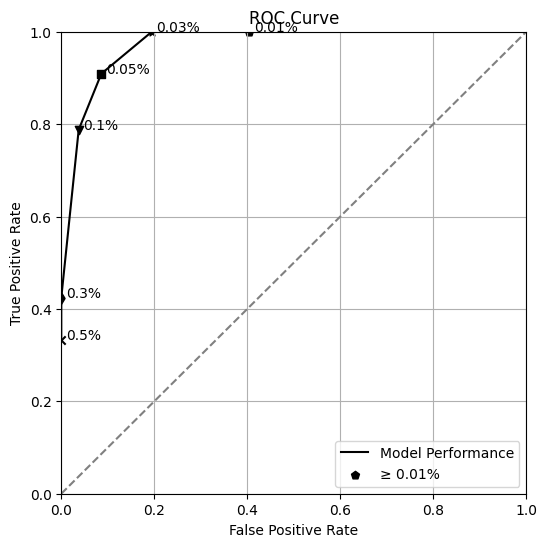

In [27]:
#plot ROC for various sensitivities
bloom_thresh = np.percentile(paper_data['Avg_Chloro'].iloc[:532],95)
print(f'Bloom threshold is {bloom_thresh}')
observations = paper_data['Avg_Chloro'].iloc[-1*len(results):] > bloom_thresh
p_list = [0.01,0.03,0.05,0.1,0.3,0.5]
samp = 200
num_models = 1000
TP_list = []
FP_list = []
for p in p_list:
    results = ensemble_binary_bloom(parameters,samp=samp,p=p,bloom_thresh=bloom_thresh,n=num_models)
    eval = eval_ensemble(observations, results)
    TP_list.append(eval[1])
    FP_list.append(eval[2])

markers = ['p', '*', 's', 'v', 'd', 'x']  
plt.figure(figsize=(6,6))
plt.plot(FP_list, TP_list, linestyle='-', color='black', marker='None', label="Model Performance")

for i, (fp, tp, p, marker) in enumerate(zip(FP_list, TP_list, p_list, markers)):
    plt.scatter(fp, tp, marker=marker, color='black', label=f"≥ {p}%" if i == 0 else "")
    plt.text(fp + 0.01, tp, f"{p}%", fontsize=10)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.title("ROC Curve")
plt.show()

### Questions:
- Now that I can predict blooms for every week how can this be translated for every day?
    - MVCM?